In [ ]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [1]:
# export

from pathlib import Path

import random
import numpy as np
from natsort import natsorted

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [2]:
from lunglens.core import *
from lunglens.data import *

### Basic dataset

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [3]:
# export

default_dict = {
    'slices_per_scan': 4,
    'inter_slice_distance': 40
}

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, transform=None, config=default_dict):
        self.scans = list(Path(datasets_root).glob('*/*'))
        self.config = config
        self.transform = transform
        self.slices_cache = {}

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            slices_files = map(str, scan_dir.glob('*.npy'))
            
            # natural sorting of files
            self.slices_cache[scan_dir] = np.array(natsorted(slices_files))
        
        slices_files = self.slices_cache[scan_dir]
        
        # calculate num of cobinations based on total items count, return count and step size
        cobinations_n = len(slices_files) - self.config['inter_slice_distance'] * (self.config['slices_per_scan'] - 1)
        
        # retrun slices according to config
        idx_first_slice = np.random.randint(cobinations_n)
        idx_list = idx_first_slice + self.config['inter_slice_distance'] * np.arange(self.config['slices_per_scan'])
        
        random_slices = lmap(np.load, slices_files[idx_list])
        
        # augment two copies of selected random files 
        aug_slices_0 = self.aug(random_slices)
        aug_slices_1 = self.aug(random_slices)
        
        return aug_slices_0, aug_slices_1
    
    def aug(self, slices):
        if self.transform:
            slices = [self.transform(image=s)['image'] for s in slices]
        
        return np.stack(slices)


In [4]:
# this just an example
tfms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(384, 384)
], p=1)

In [5]:
dataset = RandomSlicerDataset('../data/prepared', transform=tfms)
len(dataset)

175

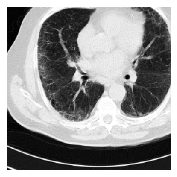

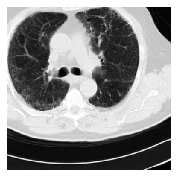

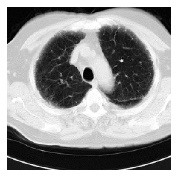

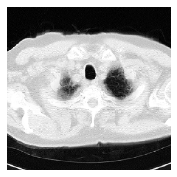

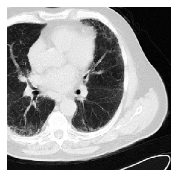

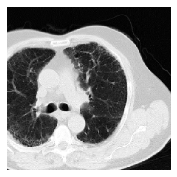

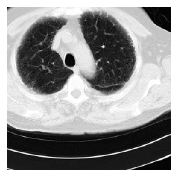

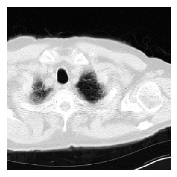

In [6]:
#print_slice(random.choice(random.choice(dataset)))
for slice_images in random.choice(dataset):
    for slice_img in slice_images:
        print_slice(slice_img, figsize=(3, 3))


#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [7]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 760 ms


In [8]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 675 ms


#### Testing with default dataloader

In [9]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [10]:
# export

def squash_scan_batches(superbatch):
    shape = list(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    shape[0] = 1
    
    return superbatch.view(*shape)


In [11]:
squash_scans = True

In [12]:
for superbatch0, superbatch1 in loader:
    break

In [13]:
type(superbatch0), superbatch0.shape

(torch.Tensor, torch.Size([8, 4, 384, 384]))

In [14]:
if squash_scans:
    shape = list(superbatch0.shape)
    reshaped_batch0 = squash_scan_batches(superbatch0)
    reshaped_batch1 = squash_scan_batches(superbatch1)
    print(reshaped_batch0.shape)

torch.Size([1, 32, 384, 384])


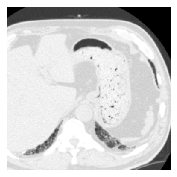

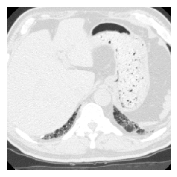

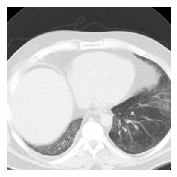

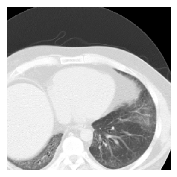

In [15]:
print_slice(superbatch0[0][1], figsize=(3, 3))
print_slice(superbatch1[0][1], figsize=(3, 3))
print_slice(superbatch0[1][1], figsize=(3, 3))
print_slice(superbatch1[1][1], figsize=(3, 3))

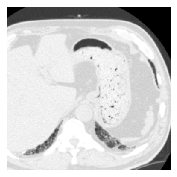

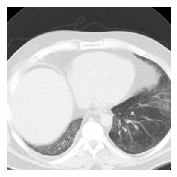

In [16]:
print_slice(reshaped_batch0[0][1], figsize=(3, 3))
print_slice(reshaped_batch0[0][4 + 1], figsize=(3, 3))